In [1]:
import os
import numpy as np
import random
import cv2
from matplotlib import pyplot as plt

In [2]:
data_img = os.listdir('../data/img')
def get_img():
    return "../data/img/"+random.choice(data_img)

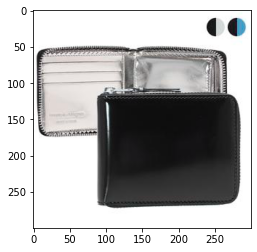

In [3]:
img = get_img()
plt.imshow(cv2.imread(img))

# Sélection précise des objets dans l'image

In [4]:
def methode1(img=img):
    #https://docs.opencv.org/master/d3/db4/tutorial_py_watershed.html
    img = cv2.imread(img)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    # noise removal
    kernel = np.ones((3,3),np.uint8)
    opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)
    # sure background area
    sure_bg = cv2.dilate(opening,kernel,iterations=3)
    # Finding sure foreground area
    dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
    ret, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)
    # Finding unknown region
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg,sure_fg)
    # Marker labelling
    ret, markers = cv2.connectedComponents(sure_fg)
    # Add one to all labels so that sure background is not 0, but 1
    markers = markers+1
    # Now, mark the region of unknown with zero
    markers[unknown==255] = 0
    markers = cv2.watershed(img,markers)
    img[markers == -1] = [255,0,0]
    plt.imshow(img)

In [5]:
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
from scipy import ndimage
def methode2(img=img):
    # Load in image, convert to gray scale, and Otsu's threshold
    image = cv2.imread(img)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

    # Compute Euclidean distance from every binary pixel
    # to the nearest zero pixel then find peaks
    distance_map = ndimage.distance_transform_edt(thresh)
    local_max = peak_local_max(distance_map, indices=False, min_distance=20, labels=thresh)

    # Perform connected component analysis then apply Watershed
    markers = ndimage.label(local_max, structure=np.ones((3, 3)))[0]
    labels = watershed(-distance_map, markers, mask=thresh)

    # Iterate through unique labels
    total_area = 0
    for label in np.unique(labels):
        if label == 0:
            continue

        # Create a mask
        mask = np.zeros(gray.shape, dtype="uint8")
        mask[labels == label] = 255

        # Find contours and determine contour area
        cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = cnts[0] if len(cnts) == 2 else cnts[1]
        c = max(cnts, key=cv2.contourArea)
        area = cv2.contourArea(c)
        total_area += area
        cv2.drawContours(image, [c], -1, (36,255,12), 4)
    plt.imshow(image)

In [6]:
def methode3(img=img):
    # Converting the image to grayscale.
    frame = cv2.imread(img)
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Using the Canny filter to get contours
    edges = cv2.Canny(gray, 20, 30)
    # Using the Canny filter with different parameters
    edges_high_thresh = cv2.Canny(gray, 60, 120)
    # Stacking the images to print them together
    # For comparison
    images = np.hstack((gray, edges, edges_high_thresh))

    # Display the resulting frame
    plt.imshow(images)

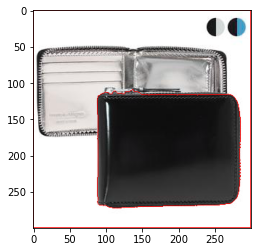

In [7]:
methode1(img)

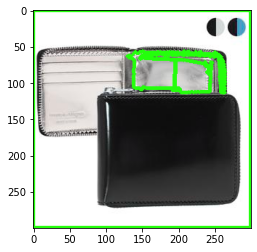

In [8]:
methode2(img)

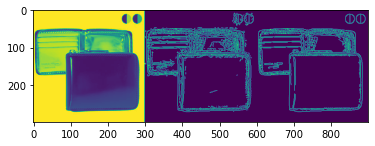

In [9]:
methode3(img)

# Extraction des objets dans les images

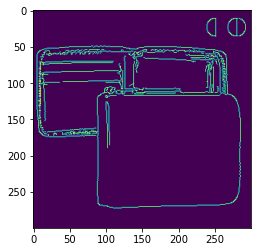

In [10]:
image = cv2.imread(img)
original = image.copy()
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (3, 3), 0)
canny = cv2.Canny(blurred, 120, 255, 1)
kernel = np.ones((5,5),np.uint8)
dilate = cv2.dilate(canny, kernel, iterations=1)

# Find contours
cnts = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]

# Iterate thorugh contours and filter for ROI
image_number = 0
for c in cnts:
    x,y,w,h = cv2.boundingRect(c)
    cv2.rectangle(image, (x, y), (x + w, y + h), (36,255,12), 2)
    ROI = original[y:y+h, x:x+w]
    #cv2.imwrite("ROI_{}.png".format(image_number), ROI)
    image_number += 1

plt.imshow(canny)

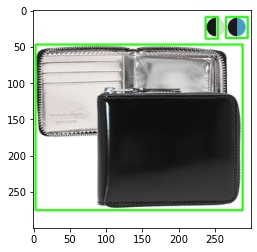

In [11]:
plt.imshow(image)